In [2]:
#!pip install tscv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

- Collect average transaction size for a credit card
- Average longitude and latitude of transactions
- Average time of transaction
- 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
folder_location = '/content/gdrive/MyDrive/Colab Notebooks/DS4400: ML Project/' 
training = pd.read_csv(folder_location + 'fraudTrain.csv')  
# testing = pd.read_csv(folder_location + 'fraudTest.csv')
X_train = pd.read_csv(folder_location + 'X_train_eng.csv').drop(["Unnamed: 0"], axis=1)
y_train = pd.read_csv(folder_location + 'y_train.csv').drop(["Unnamed: 0"], axis=1)  
X_test = pd.read_csv(folder_location + 'X_test_agg.csv').drop(["Unnamed: 0", "is_fraud"], axis=1)  
y_test = pd.read_csv(folder_location + 'y_test.csv').drop(["Unnamed: 0"], axis=1)   


In [5]:
training.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
# visualize the target variable - clearly our data is highly imbalanced and something must be done to fix this issue
g = sns.countplot(testing['is_fraud'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

NameError: ignored

Text(0.5, 1.0, 'Heatmap of Feature Correlation')

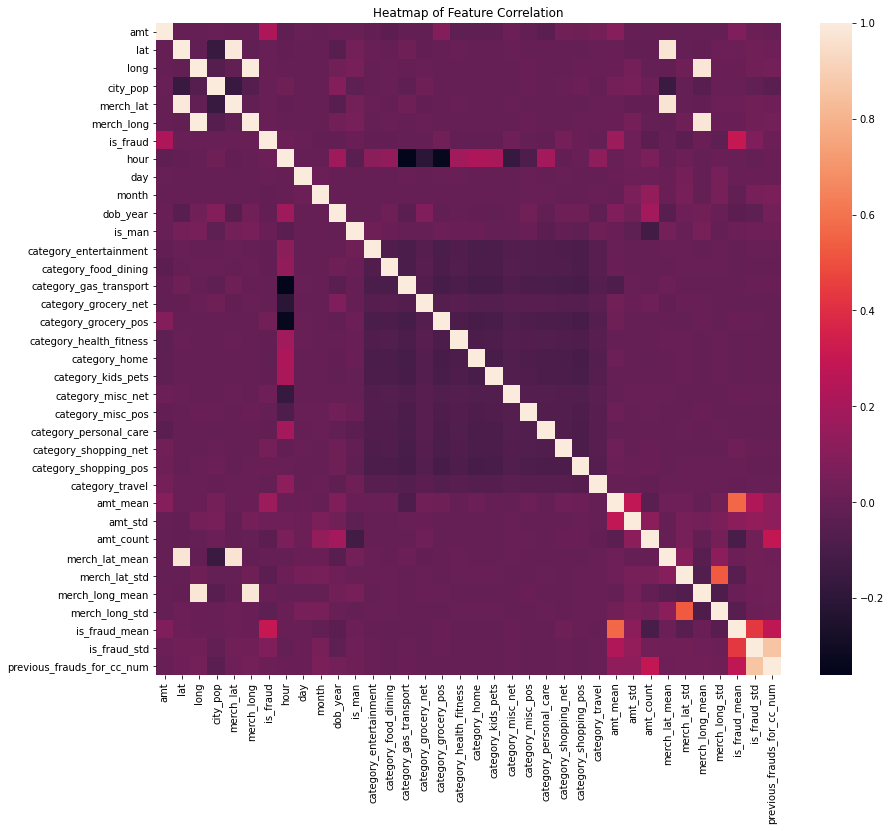

In [7]:
corr = X_train.corr()
plt.figure(figsize=(14,12))
heat = sns.heatmap(data=corr)
plt.title("Heatmap of Feature Correlation")


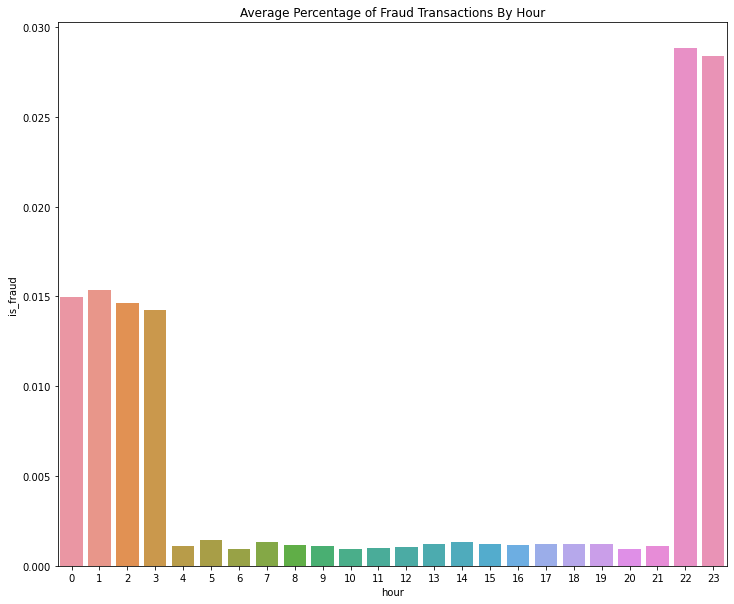

In [21]:
is_fraud_by_hour = X_train[['hour', "is_fraud"]]
is_fraud_by_hour_agg = is_fraud_by_hour.groupby(["hour"]).agg("mean")
plt.figure(figsize=(12,10))
plt.title("Average Percentage of Fraud Transactions By Hour")
sns.barplot(x=is_fraud_by_hour_agg.index, y=is_fraud_by_hour_agg['is_fraud'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


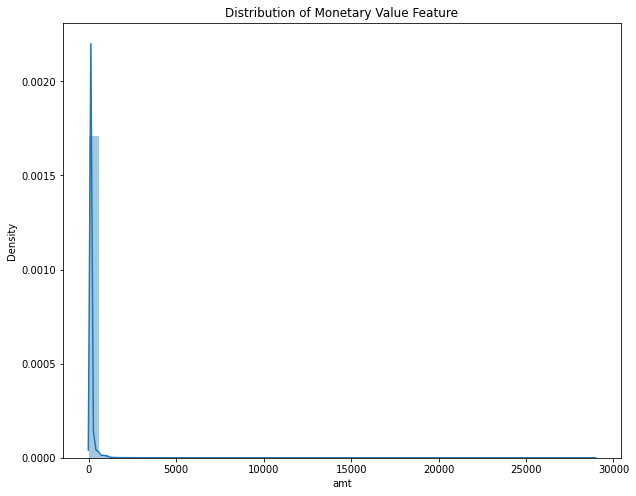

In [23]:
plt.figure(figsize=(10,8))
plt.title("Distribution of Monetary Value Feature")
sns.distplot(X_train['amt'])

In [6]:
from time import mktime
from sklearn.preprocessing import MinMaxScaler

def normalize_features(X_train, X_test):
  scaler = MinMaxScaler()
  X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
  X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_train.columns)
  return X_train_scaled, X_test_scaled

def engineer_datetime(df):
  df["datetime"] = df["trans_date_trans_time"].apply(pd.to_datetime)
  df["hour"] = df["datetime"].dt.hour
  df["day"] = df["datetime"].dt.day
  df["month"] = df["datetime"].dt.month
  df["unix_purchase_time"] = df["datetime"].apply(lambda dt: mktime(dt.timetuple()))
  dob_dt = df["dob"].apply(pd.to_datetime)
  dob_year = dob_dt.dt.year 
  df["dob_year"] = dob_year
  df["unix_dob"] = dob_dt.apply(lambda dt: mktime(dt.timetuple()))
  df = df.drop(["trans_date_trans_time", "dob"], axis=1)
  return df

def engineer_features(df):
  df = engineer_datetime(df)
  df = df.drop(["state", "city", "Unnamed: 0", "merchant", "first", "last", "street", "zip", "job", "unix_time"], axis=1)
  df["is_man"] = df["gender"].apply(lambda x: 0 if x == "F" else 1)
  df = df.drop("gender", axis=1)
  df.reset_index(inplace=True)
  #df = pd.DataFrame(df, dtype={'amt': float, 'lat': float, 'long': float, 'city_pop': float, 'merch_lat': float, 'merch_long': float})
  df = df.astype({'amt': float, 'lat': float, 'long': float, 'city_pop': float, 'merch_lat': float, 'merch_long': float})
  obj_df = df.select_dtypes(include=['object']).copy()
  obj_df_encoded = pd.get_dummies(obj_df, columns=["category"], prefix=["category"])
  df = df.drop(["category"], axis=1)
  obj_df_encoded.reset_index(inplace=True)
  df = pd.concat([df,obj_df_encoded],axis=1).drop("index", axis=1)
  df = df.loc[:,~df.columns.duplicated()]
  means = df.apply(concat_averages, frame=df, axis=1)
  df = df.merge(means, left_on='trans_num', right_on='trans_num')
  df.drop(['datetime', 'cc_num', 'trans_num'], axis=1, inplace=True)
  return df


def f(x):
    d = {}
    d['amt_mean'] = x['amt'].mean()
    d['amt_std'] = x['amt'].std()
    d['amt_count'] = x['amt'].count()
    d['merch_lat_mean'] = x['merch_lat'].mean()
    d['merch_lat_std'] = x['merch_lat'].std()
    d['merch_long_mean'] = x['merch_long'].mean()
    d['merch_long_std'] = x['merch_long'].std()
    d['is_fraud_mean'] = x['is_fraud'].mean()
    d['is_fraud_std'] = x['is_fraud'].std()
    d['previous_frauds_for_cc_num'] = d['amt_count'] * d['is_fraud_mean']
    return pd.Series(d, index=['amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num'])

def concat_averages(row, frame):
  date = row['datetime']
  cc_num = row['cc_num']
  frame_before_date = frame.loc[ (frame["cc_num"] == cc_num) & (frame['datetime'] < date)].copy()
  frame_before_date.drop(columns=['city_pop', 'lat', 'long'], inplace=True)
  cc_averages = frame_before_date.groupby("cc_num").apply(f)
  cc_averages = cc_averages.fillna(0)
  indices = ['amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num']
  if len(cc_averages.values) == 0:
    zeros = np.zeros(len(indices))
    series = pd.Series(zeros, index=indices)
  else:
    series = pd.Series(cc_averages.values[0], index=indices)
  series['trans_num'] = row['trans_num']
  return series


In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

y_train = training["is_fraud"]
X_train = training.drop(["is_fraud"], axis = 1)

# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=.1)

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Before undersampling:  Counter({0: 1289169, 1: 7506})
After undersampling:  Counter({0: 75060, 1: 7506})


In [ ]:
#PART 2
# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split


x_train_unused, X_test, y_train, y_test = train_test_split(testing.drop(["is_fraud"], axis=1), testing["is_fraud"], test_size = 0.1)

X_train_under_df = pd.DataFrame(X_train_under, columns=training.drop(["is_fraud"], axis=1).columns)
X_test_df = pd.DataFrame(X_test, columns=training.drop(["is_fraud"], axis=1).columns)
X_train_under_df['is_fraud'] = y_train_under
print(X_train_under_df.shape, X_test_df.shape)
X_train_under_df = engineer_features(X_train_under_df)
X_test_df['is_fraud'] = y_test
X_test_df = engineer_features(X_test_df)

X_train_under_df.drop('is_fraud', axis=1, inplace=True)
X_test_df.drop('is_fraud', axis=1, inplace=True)

X_train_under_df.head()

NameError: ignored

In [ ]:
def create_aggregated_df_to_apply_to_test(train_df):
  lat_long_df = train_df[['lat', 'long', 'amt_count']]
  lat_long_df_agg = lat_long_df.groupby(['lat', 'long']).agg('max')
  lat_long_df_agg.set_index(['amt_count'], append=True, inplace=True)
  lat_long_df_agg.head()
  indices = ['lat', 'long', 'amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num']
  cc_averages_by_lat = train_df[indices]
  cc_averages_by_lat.set_index(['lat', 'long', 'amt_count'], inplace=True)
  df_with_maxes = pd.merge(lat_long_df_agg, cc_averages_by_lat, left_index=True, right_index=True, how="inner")
  df_with_maxes.reset_index(level='amt_count', inplace=True)
  return df_with_maxes

agg_df_to_apply_to_test = create_aggregated_df_to_apply_to_test(X_train_under_df)


In [ ]:
def map_aggregations(row, frame):
  lat = row['lat']
  long = row['long']
  if (lat, long) not in frame.index:
    return row
  else:
    frame_row = frame.loc[(lat, long)]
    if row['amt_count'] == 0:
      row['amt_mean'] = frame_row['amt_mean']
      row['amt_std'] = frame_row['amt_std']
      row['amt_count'] = frame_row['amt_count']
      row['merch_lat_mean'] = frame_row['merch_lat_mean']
      row['merch_lat_std'] = frame_row['merch_lat_std']
      row['merch_long_mean'] = frame_row['merch_long_mean']
      row['merch_long_std'] = frame_row['merch_long_std']
      row['is_fraud_mean'] = frame_row['is_fraud_mean']
      row['is_fraud_std'] = frame_row['is_fraud_std']
      row['previous_frauds_for_cc_num'] = frame_row['previous_frauds_for_cc_num']
      return row
    else:
      test_count = row['amt_count']
      frame_row_count = frame_row['amt_count']

      row['amt_mean'] = combine_means(row['amt_mean'], frame_row['amt_mean'], test_count, frame_row_count)
      row['amt_std'] = combine_std(row['amt_std'], frame_row['amt_std'], test_count, frame_row_count)
      row['amt_count'] = test_count + frame_row_count
      row['merch_lat_mean'] = combine_means(row['merch_lat_mean'], frame_row['merch_lat_mean'], test_count, frame_row_count)
      row['merch_lat_std'] = combine_std(row['merch_lat_std'], frame_row['merch_lat_std'], test_count, frame_row_count)
      row['merch_long_mean'] = combine_means(row['merch_long_mean'], frame_row['merch_long_mean'], test_count, frame_row_count)
      row['merch_long_std'] = combine_std(row['merch_long_std'], frame_row['merch_long_std'], test_count, frame_row_count)
      row['is_fraud_mean'] = combine_means(row['is_fraud_mean'], frame_row['is_fraud_mean'], test_count, frame_row_count)
      row['is_fraud_std'] = combine_std(row['is_fraud_std'], frame_row['is_fraud_std'], test_count, frame_row_count)
      row['previous_frauds_for_cc_num'] = frame_row['previous_frauds_for_cc_num'] + row['previous_frauds_for_cc_num']
      return row

def combine_means(mean1, mean2, n1, n2):
  return (mean1 * n1 + mean2 * n2) / (n1 + n2)

def combine_std(std1, std2, n1, n2):
  var1 = (std1 ** 2) / n1
  var2 = (std2 ** 2) / n2
  return np.sqrt((var1 + var2) / 2)   


In [ ]:
def apply_aggregation_df_to_test(test_df, agg_df):
  return test_df.apply(map_aggregations, frame=agg_df, axis=1)

X_test_df_agg = apply_aggregation_df_to_test(X_test_df, agg_df_to_apply_to_test)

In [ ]:
def add_blank_columns(df_train, df_test):
  for column in df_train.columns:
    if column not in df_test.columns:
      df_test[column] = 0
  for column2 in df_test.columns:
    if column2 not in df_train.columns:
      df_train[column2] = 0
  return df_train, df_test
##X_train_under_df, X_test_df = add_blank_columns(X_train_under_df, X_test_df)

In [7]:
X_train['hr_sin'] = np.sin(X_train['hour']*(2.*np.pi/24))
X_train['hr_cos'] = np.cos(X_train['hour']*(2.*np.pi/24))
X_train['mnth_sin'] = np.sin((X_train['month']-1)*(2.*np.pi/12))
X_train['mnth_cos'] = np.cos((X_train['month']-1)*(2.*np.pi/12))

X_test['hr_sin'] = np.sin(X_test['hour']*(2.*np.pi/24))
X_test['hr_cos'] = np.cos(X_test['hour']*(2.*np.pi/24))
X_test['mnth_sin'] = np.sin((X_test['month']-1)*(2.*np.pi/12))
X_test['mnth_cos'] = np.cos((X_test['month']-1)*(2.*np.pi/12))

X_train.drop(['is_fraud'], axis=1, inplace=True)
X_train["amt_difference"] = (X_train["amt_mean"] - X_train["amt"]) #/ X_train["amt_std"]
X_train["lat_difference"] = (X_train["merch_lat_mean"] - X_train["merch_lat"]) #/ X_train["merch_lat_std"]
X_train["merch_long_difference"] = (X_train["merch_long_mean"] - X_train["merch_long"]) #/ X_train["merch_long_std"]
X_train = X_train.drop(["is_man", "city_pop", "dob_year", "amt_count", 'month', 'hour'], axis=1)

X_test["amt_difference"] = (X_test["amt_mean"] - X_test["amt"]) #/ X_test["amt_std"]
X_test["lat_difference"] = (X_test["merch_lat_mean"] - X_test["merch_lat"]) #/ X_test["merch_lat_std"]
X_test["merch_long_difference"] = (X_test["merch_long_mean"] - X_test["merch_long"]) #/ X_test["merch_long_std"]
X_test = X_test.drop(["is_man", "city_pop", "dob_year", "amt_count", 'month', 'hour'], axis=1)

In [8]:
# scaling features 

X_train_scaled_df, X_test_scaled_df = normalize_features(X_train, X_test)
#X_train_scaled_df.to_csv(folder_location + "X_train_aggregated_and_scaled.csv")
#X_test_scaled_df.to_csv(folder_location + "X_test_aggregated_and_scaled.csv")

In [32]:
X_train_scaled_df.tail()

,amt,lat,long,merch_lat,merch_long,day,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,amt_mean,amt_std,merch_lat_mean,merch_lat_std,merch_long_mean,merch_long_std,is_fraud_mean,is_fraud_std,previous_frauds_for_cc_num,hr_sin,hr_cos,mnth_sin,mnth_cos,amt_difference,lat_difference,merch_long_difference
1296670,0.000503,0.379084,0.544346,0.367421,0.551347,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044096,0.036271,0.561719,0.415637,0.322933,0.435419,0.005952,0.108820,0.473684,0.5,0.0,0.75,0.066987,0.954394,0.984346,0.006415
1296671,0.001751,0.412281,0.902174,0.410026,0.886727,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070625,0.042853,0.584750,0.426240,0.533288,0.439388,0.015094,0.172596,0.421053,0.5,0.0,0.75,0.066987,0.954456,0.976839,0.015377
1296672,0.003625,0.276699,0.612486,0.300969,0.617133,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045493,0.048668,0.489832,0.409624,0.363194,0.439553,0.005317,0.102868,0.578947,0.5,0.0,0.75,0.066987,0.951479,0.961057,0.007183
1296673,0.002553,0.499837,0.646029,0.490098,0.636080,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066802,0.033738,0.645154,0.415553,0.382865,0.442897,0.003955,0.088779,0.421053,0.5,0.0,0.75,0.066987,0.953510,0.979391,0.015390
1296674,0.000114,0.553210,0.530050,0.568003,0.526323,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048113,0.027980,0.682423,0.422747,0.314591,0.446493,0.005295,0.102664,0.421053,0.5,0.0,0.75,0.066987,0.954955,0.960951,0.013017


In [ ]:
X_test_scaled_df.head()

,amt,lat,long,city_pop,merch_lat,merch_long,hour,day,month,dob_year,is_man,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,amt_mean,amt_std,amt_count,merch_lat_mean,merch_lat_std,merch_long_mean,merch_long_std,is_fraud_mean,is_fraud_std,previous_frauds_for_cc_num
0,0.000064,0.298692,0.867121,0.114727,0.308536,0.857102,0.521739,0.666667,0.454545,0.543210,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.049069,0.043602,0.499680,0.505779,0.411062,0.512953,0.445257,0.007692,0.123596,0.631579
1,0.000996,0.434867,0.565239,0.000096,0.421239,0.568699,0.521739,0.666667,0.454545,0.814815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.042621,0.061434,0.668802,0.600080,0.418344,0.335279,0.449110,0.006705,0.115440,0.736842
2,0.001391,0.442414,0.942836,0.011860,0.442800,0.927345,0.521739,0.666667,0.454545,0.567901,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062305,0.045513,0.825112,0.605235,0.416657,0.557376,0.440261,0.002717,0.073635,0.368421
3,0.002040,0.183058,0.868312,0.018834,0.201817,0.860288,0.521739,0.666667,0.454545,0.777778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.040411,0.063186,0.488469,0.425210,0.416574,0.513605,0.437670,0.000000,0.000000,0.000000
4,0.000076,0.519129,0.825355,0.000379,0.534860,0.810131,0.521739,0.666667,0.454545,0.382716,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.044441,0.038202,0.651185,0.658598,0.412812,0.488217,0.433355,0.005411,0.103770,0.578947


In [ ]:
print(np.isnan(X_test.any())) #and gets False
print(np.isfinite(X_test.all()))
print(np.isnan(np.min(X_test)))

amt                        False
lat                        False
long                       False
merch_lat                  False
merch_long                 False
hour                       False
day                        False
month                      False
category_entertainment     False
category_food_dining       False
category_gas_transport     False
category_grocery_net       False
category_grocery_pos       False
category_health_fitness    False
category_home              False
category_kids_pets         False
category_misc_net          False
category_misc_pos          False
category_personal_care     False
category_shopping_net      False
category_shopping_pos      False
category_travel            False
amt_mean                   False
amt_std                    False
merch_lat_mean             False
merch_lat_std              False
merch_long_mean            False
merch_long_std             False
is_fraud_mean              False
is_fraud_std               False
amt_differ

In [35]:
## Feature Research - Running Random Forest for Feature Importances

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_scaled_df, y_train)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Text(0.5, 0, 'Random Forest Feature Importance')

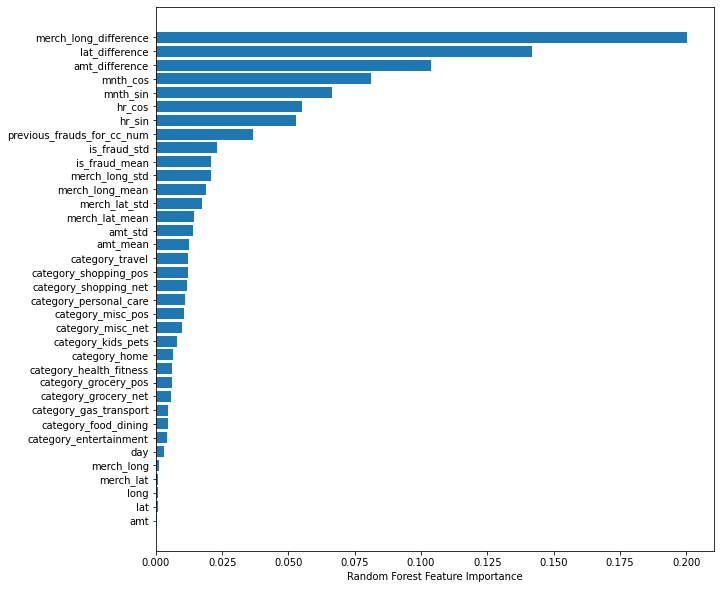

In [36]:
rf.feature_importances_
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train_scaled_df.columns)
feature_importances.to_csv(folder_location + "RF_feature_importances.csv")
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(X_train_scaled_df.columns, rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


model = DecisionTreeClassifier()
model2 = RandomForestClassifier()

over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.3)
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train_scaled_df, y_train, scoring='recall', cv=cv, n_jobs= -1)

KeyboardInterrupt: ignored

In [ ]:
scores = cross_val_score(pipeline, X_train_scaled_df, y_train, scoring='recall', cv=cv, n_jobs= -1)

KeyboardInterrupt: ignored

In [ ]:
over = SMOTE(sampling_strategy = 0.01)
under = RandomUnderSampler(sampling_strategy = 0.1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)


X_sampled, y_sampled = pipeline.fit_resample(X_train_scaled_df, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
undersample = RandomUnderSampler(sampling_strategy = 0.1)
X_train_under, y_train_under = undersample.fit_resample(X_train_scaled_df, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df = pd.DataFrame(y_train_under, columns=["is_fraud"])

print(Counter(df["is_fraud"]))



Counter({0: 75060, 1: 7506})


In [ ]:
df = pd.DataFrame(y_sampled)
df.head()
#g = sns.countplot(df.iloc[0])
#g.set_xticklabels(['Not Fraud','Fraud'])
#plt.show()

from collections import Counter

counter = Counter(y_sampled)
print(counter)

Counter({0: 429720, 1: 128916})


In [ ]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train_scaled_df[-300000:], y_train[-300000:])



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
from sklearn.metrics import classification_report

pred = tree.predict(X_test_scaled_df)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.41      0.73      0.52      2145

    accuracy                           0.99    555719
   macro avg       0.70      0.86      0.76    555719
weighted avg       1.00      0.99      1.00    555719



In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X_train_under, y_train_under)

predictions = ada.predict(X_test_scaled_df)

f1 = f1_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

recall = tp / (tp + fn)
specificity = tn / (fp + tn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + fp + tn + fn) 

print(f1)
print(recall)
print(specificity)
print(precision)
print(accuracy)
print(confusion_matrix(y_test, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.041687818547322675
0.9571095571095571
0.8296596299681704
0.021307953377824367
0.83015156940828
[[459278  94296]
 [    92   2053]]


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

f1 = f1_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

recall = tp / (tp + fn)
specificity = tn / (fp + tn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + fp + tn + fn) 

print(f1)
print(recall)
print(specificity)
print(precision)
print(accuracy)
print(confusion_matrix(y_test, pred))

0.009677328607196107
0.8018648018648019
0.36484553104011386
0.004868039340550485
0.3665323661778705
[[201969 351605]
 [   425   1720]]


In [1]:
import xgboost as xgb

In [12]:
## Perform cross validation to get preliminary best models
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, roc_curve
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
!pip install tscv
from tscv import GapWalkForward
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

def perform_cross_validation(metrics_df, model, model_name, X_training, y_training):
  tscv = GapWalkForward(n_splits=10, gap_size=0, test_size=10000)

  g_means = []
  f1s = []
  f2s = []
  precisions = []
  recalls = []
  accuracies = []
  errors = []

  for train_index, test_index in tscv.split(X_training):
    if model_name == "XG_Boost":
      X_train, X_test = X_training.iloc[train_index], X_training.iloc[test_index]
      y_train, y_test = y_training.iloc[train_index], y_training.iloc[test_index]

      # XGB Classifier
      eval_set = [(X_train, y_train), (X_test, y_test)]

      # Fit the classifier to the training set
      model.fit(X_train, y_train, eval_metric=["aucpr"], eval_set=eval_set, verbose=True)
      results = model.evals_result()

      # Predict the labels of the test set: preds
      predictions = model.predict(X_test)

    else:
      X_train, X_test = X_training.iloc[train_index], X_training.iloc[test_index]
      y_train, y_test = y_training.iloc[train_index], y_training.iloc[test_index]

      print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

      model.fit(X_train, y_train.values.ravel())
      predictions = model.predict(X_test)

    f1 = f1_score(y_test, predictions)
    f2 = fbeta_score(y_test, predictions, beta=2)

    # print(confusion_matrix(y_test, predictions))
    # print(classification_report(y_test, predictions))

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    recall = tp / (tp + fn)
    specificity = tn / (fp + tn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)

    g_mean = np.sqrt(recall * specificity)

    f1s.append(f1)
    f2s.append(f2)
    g_means.append(g_mean)
    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    errors.append(1- accuracy)
  
  print(f1s, f2s, g_means, precisions, recalls)
  metrics_df.loc[model_name] = [np.mean(f1s), np.mean(f2s), np.mean(g_means), np.mean(recalls), np.mean(precisions), np.mean(accuracies), np.mean(errors)]

  return model, metrics_df

def compare_models(models, model_names, X_training, y_training, X_testing, y_testing):
  cross_validation_model_scores = pd.DataFrame(data=None, columns = ["Model Name", "F1-Score", "F2-Score", "G-Mean", "Recall for 1", "Precision for 1", "Accuracy", "Error"])
  cross_validation_model_scores.set_index('Model Name', inplace=True)
  # plot no skill roc curve
  plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
  for i in range(len(models)):
    model, cross_validation_model_scores = perform_cross_validation(cross_validation_model_scores, models[i], model_names[i], X_training, y_training)
    predictions = model.predict(X_testing)
    print(confusion_matrix(y_testing, predictions))
    print(classification_report(y_testing, predictions))
    f1 = f1_score(y_testing, predictions)
    tn, fp, fn, tp = confusion_matrix(y_testing, predictions).ravel()

    recall = tp / (tp + fn)
    specificity = tn / (fp + tn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    error = 1 - accuracy
    print("F1: ", f1)
    print("Recall: ", recall)
    print("Specificity: ", specificity)
    print("Precision: ", precision)
    print("Accuracy: ", accuracy)
    print("Error: ", error)

    get_precision_recall_curve(model, model_names[i], X_testing, y_testing)

  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  return cross_validation_model_scores

def get_precision_recall_curve(model, model_name, x_test, y_test):
  # predict probabilities
  yhat = model.predict_proba(x_test)
  # retrieve just the probabilities for the positive class
  pos_probs = yhat[:, 1]

  # calculate roc curve for model
  fpr, tpr, _ = roc_curve(y_test, pos_probs)
  # plot model roc curve
  plt.plot(fpr, tpr, marker='.', label=model_name)
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')


model_names = ["LogRegression", "LDA", "Naive Bayes", "Decision Trees", "kNN", "SVM", "Random Forest", "XGBoost", "AdaBoost"]
some_model_names = ["LogReg", "Random Forest", "AdaBoost", "Decision Trees", "SVC"]
some_models = [LogisticRegression(random_state=0, max_iter=2000), RandomForestClassifier(random_state=0), AdaBoostClassifier(random_state=0), DecisionTreeClassifier(random_state=0), SVC(random_state=0)]

other_names = ["kNN", "Naive Bayes"]
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

other_models = [KNeighborsClassifier(), GaussianNB()]

probabilistic_model_names = ["kNN", "LDA", "AdaBoost", "Decision Trees"]
probabilistic_models = [KNeighborsClassifier(), LinearDiscriminantAnalysis(), AdaBoostClassifier(), DecisionTreeClassifier()]

#compare_models(probabilistic_models, probabilistic_model_names, X_train_scaled_df.tail(300000), y_train.tail(300000), X_test_scaled_df.head(100000), y_test.head(100000))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-aucpr:0.490246	validation_1-aucpr:0.29934
[1]	validation_0-aucpr:0.495141	validation_1-aucpr:0.305199
[2]	validation_0-aucpr:0.497422	validation_1-aucpr:0.316146
[3]	validation_0-aucpr:0.515793	validation_1-aucpr:0.337189
[4]	validation_0-aucpr:0.516472	validation_1-aucpr:0.356786
[5]	validation_0-aucpr:0.531031	validation_1-aucpr:0.368989
[6]	validation_0-aucpr:0.53619	validation_1-aucpr:0.372852
[7]	validation_0-aucpr:0.530615	validation_1-aucpr:0.373643
[8]	validation_0-aucpr:0.659647	validation_1-aucpr:0.521847
[9]	validation_0-aucpr:0.663799	validation_1-aucpr:0.519461
[10]	validation_0-aucpr:0.667748	validation_1-aucpr:0.524709
[11]	validation_0-aucpr:0.671281	validation_1-aucpr:0.525703
[12]	validation_0-aucpr:0.672417	validation_1-aucpr:0.532464
[13]	validation_0-aucpr:0.680532	validation_1-aucpr:0.548817
[14]	validation_0-aucpr:0.687858	validation_1-aucpr:0.563515
[15]	validation_0-aucpr:0.693822	validation_1-aucpr:0.567511
[16]	validation_0-aucpr:0.721446	val

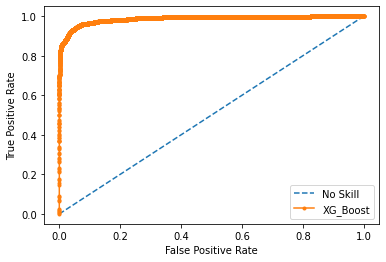

,F1-Score,F2-Score,G-Mean,Recall for 1,Precision for 1,Accuracy,Error
Model Name,,,,,,,
XG_Boost,0.790904,0.73353,0.834628,0.701524,0.92562,0.99788,0.00212


In [13]:
compare_models([xgb.XGBClassifier(objective='binary:logistic', seed=123)], ["XG_Boost"], X_train_scaled_df.tail(300000), y_train.tail(300000), X_test_scaled_df.head(100000), y_test.head(100000))


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-aucpr:0.473096	validation_1-aucpr:0.375278
[1]	validation_0-aucpr:0.485701	validation_1-aucpr:0.38767
[2]	validation_0-aucpr:0.485734	validation_1-aucpr:0.387698
[3]	validation_0-aucpr:0.498549	validation_1-aucpr:0.400857
[4]	validation_0-aucpr:0.511097	validation_1-aucpr:0.405128
[5]	validation_0-aucpr:0.511427	validation_1-aucpr:0.405159
[6]	validation_0-aucpr:0.640671	validation_1-aucpr:0.470811
[7]	validation_0-aucpr:0.643196	validation_1-aucpr:0.527758
[8]	validation_0-aucpr:0.659785	validation_1-aucpr:0.555411
[9]	validation_0-aucpr:0.662096	validation_1-aucpr:0.559086
[10]	validation_0-aucpr:0.675278	validation_1-aucpr:0.569201
[11]	validation_0-aucpr:0.679064	validation_1-aucpr:0.574106
[12]	validation_0-aucpr:0.688942	validation_1-aucpr:0.58833
[13]	validation_0-aucpr:0.691582	validation_1-aucpr:0.590826
[14]	validation_0-aucpr:0.701484	validation_1-aucpr:0.595378
[15]	validation_0-aucpr:0.710162	validation_1-aucpr:0.601836
[16]	validation_0-aucpr:0.716783	val

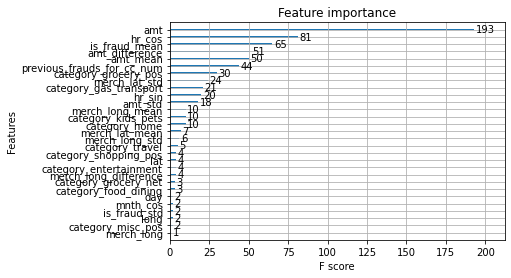

In [20]:
def train_xgb(model, X_train, y_train, X_test, y_test):

  # XGB Classifier
  eval_set = [(X_train, y_train), (X_test, y_test)]

  # Fit the classifier to the training set
  model.fit(X_train, y_train, eval_metric=["aucpr"], eval_set=eval_set, verbose=True)
  results = model.evals_result()

  # Predict the labels of the test set: preds
  predictions = model.predict(X_test)

  xgb.plot_importance(model)

  return model

model = train_xgb(xgb.XGBClassifier(objective='binary:logistic', seed=123, scale_positive_weight = 9), X_train_scaled_df.tail(300000), y_train.tail(300000), X_test_scaled_df.head(100000), y_test.head(100000))

predictions = model.predict(X_test_scaled_df)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
f1 = f1_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

recall = tp / (tp + fn)
specificity = tn / (fp + tn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + fp + tn + fn)
error = 1 - accuracy
print("F1: ", f1)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Precision: ", precision)
print("Accuracy: ", accuracy)
print("Error: ", error)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score for undersampled data:  0.5640515583681343


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test.iloc[0:50000], pred_under))
print(classification_report(y_test.iloc[0:50000], pred_under))
print("--------------------------------------------------------")
print(confusion_matrix(y_train.iloc[0:50000], pred_train))
print(classification_report(y_train.iloc[0:50000], pred_train))

[[49674   127]
 [  173    26]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49801
           1       0.17      0.13      0.15       199

    accuracy                           0.99     50000
   macro avg       0.58      0.56      0.57     50000
weighted avg       0.99      0.99      0.99     50000

--------------------------------------------------------
[[47094  2458]
 [    0   448]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     49552
           1       0.15      1.00      0.27       448

    accuracy                           0.95     50000
   macro avg       0.58      0.98      0.62     50000
weighted avg       0.99      0.95      0.97     50000



In [ ]:


ada = AdaBoostClassifier(n_estimators = 100, random_state=0)
ada.fit(X_train_scaled_df, y_train_under)
pred_test = ada.predict(X_test_scaled_df)
pred_train = ada.predict(X_train_scaled_df)
print(classification_report(y_test, pred_test))
print(classification_report(y_train_under, pred_train))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     55381
           1       0.07      0.78      0.13       191

    accuracy                           0.97     55572
   macro avg       0.54      0.87      0.56     55572
weighted avg       1.00      0.97      0.98     55572

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     75060
           1       0.93      0.88      0.91      7506

    accuracy                           0.98     82566
   macro avg       0.96      0.94      0.95     82566
weighted avg       0.98      0.98      0.98     82566



In [ ]:
print(confusion_matrix(y_test, pred_test))

[[53490  1891]
 [   42   149]]
